Pedro Ivo Vasconcelos - TP

## **Capítulo 8**
1) Para responder isto é necessário verificar se os estados $x_{2}$ e $x_{3}$ são controláveis

$C_{trb}$\=\[B $O_{bsv}$ B  $O_{bsv}$<sup>2</sup>B ⋯ $O_{bsv}$<sup>n−1</sup>B\]

In [42]:
import numpy as np
import math
import control as ctl
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import matrix_rank

# Definindo a matriz A e a matriz C
A = np.diag([0.031, 0.791, 0.791, 1.0, 1.0, 1.0, 1.0])
C = np.array([
    [0, 1, 0, 0, 0, 0, 0],  # x2
    [0, 0, 1, 0, 0, 0, 0]   # x3
])

# Definindo a matriz B
B = np.array([
    [0.1545, 0.1545],
    [2.47e-4, -2.49e-4],
    [-4.56e-5, -4.15e-5],
    [-0.0303, 0],
    [0, 0],
    [0, -0.0303],
    [0, 0]
])

# Construindo a matriz de controlabilidade
ctrb = B
for i in range(1, A.shape[0]):
    ctrb = np.hstack((ctrb, np.linalg.matrix_power(A, i) @ B))

# Calculando o posto da matriz obsv_ctrb
rank_of_controllability = matrix_rank(ctrb)
print("Posto da matriz de controlabilidade dos estados observáveis:", rank_of_controllability)

if rank_of_controllability == A.shape[0]:
    print("A matriz é completamente controlável.")
else:
    print("A matriz não é ou é parcialmente controlável.")

Posto da matriz de controlabilidade dos estados observáveis: 5
A matriz não é ou é parcialmente controlável.


Voltando analisar o problema de controlabilidade, como está na forma de Jordan dois estados pela matriz b não estão sendo alimentados por nenhuma entrada, então são estados não controláveis, e portanto não compõem a saída do sistema.

Além disso apenas dois estados compõem a saída e são observáveis.

Uma diferença da forma de Jordan para as outras formas canônicas é que a controlabilidade e observabilidade porem ser analisadas apenas analisando as matrizes.


In [43]:
#Recriando a matriz A, B e C removendo estes estados
A_reduzido = A = np.diag([0.791, 0.791])
B_reduzido = np.array([
    [2.47e-4, -2.49e-4],
    [-4.56e-5, -4.15e-5],
])
C_reduzido = np.array([
    [1, 0],  # x2
    [0, 1]   # x3
])

# Construindo a matriz de controlabilidade
ctrb = B_reduzido
for i in range(1, A_reduzido.shape[0]):
    ctrb = np.hstack((ctrb, np.linalg.matrix_power(A_reduzido, i) @ B_reduzido))

# Calculando o posto da matriz obsv_ctrb
rank_of_controllability = matrix_rank(ctrb)
print("Posto da matriz de controlabilidade dos estados observáveis:", rank_of_controllability)

if rank_of_controllability == A_reduzido.shape[0]:
    print("A matriz é completamente controlável.")
else:
    print("A matriz não é ou é parcialmente controlável.")

Posto da matriz de controlabilidade dos estados observáveis: 2
A matriz é completamente controlável.


2. 

In [44]:
#Utilizando as matrizes reduzidas e usando um dos pólos
T = 40
lambda_atual = 0.791
s = 1/T * math.log(lambda_atual)
# Nova constante de tempo desejada (duplicando a velocidade de resposta)
s_novo = s*2
lambda_novo = math.exp(s_novo*T)
print("Opção de cálculo 1:", lambda_novo)
# Outra forma de calcular a constante de tempo por conta de z = e^(sT) logo z_novo = e^(s*2*T)
print("Opção de cálculo 2:", lambda_atual**2)
#A nova matriz A será:
A_novo = np.diag([lambda_novo, lambda_novo])
print(A_novo)

Opção de cálculo 1: 0.625681
Opção de cálculo 2: 0.625681
[[0.625681 0.      ]
 [0.       0.625681]]


3.

2


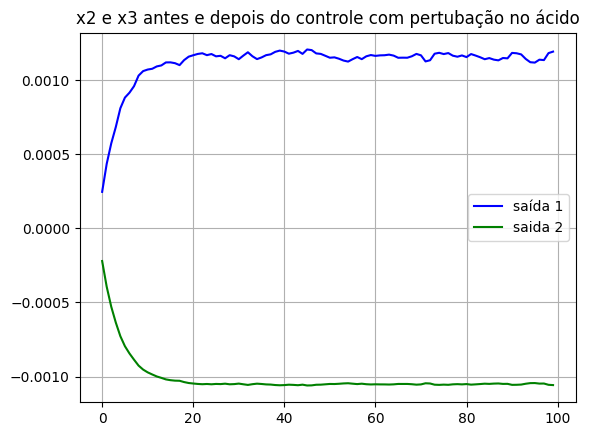

In [165]:
A_reduzido = np.diag([0.791, 0.791])
B_reduzido = np.array([
    [2.47e-4, -2.49e-4],
    [-4.56e-5, -4.15e-5],
])
C_reduzido = np.array([
    [1, 0],  # x2
    [0, 1]   # x3
])
A_novo = np.diag([0.625681, 0.625681])

N = 100
u = np.zeros((2, N))
u[0,:]=3 + np.random.normal(0, 0.05, N)
u[1,:]=2

# Simulação do sistema
x = np.array([[0, 0], [0, 0]])
y= np.dot(C_reduzido, x)
x_hist = np.zeros((2,2, N))
y_hist = np.zeros((2,2, N))

for k in range(N):
    x = np.dot(A_reduzido, x) + np.dot(B_reduzido , u[:, k])
    y = np.dot(C_reduzido, x)
    x_hist[:, :, k] = x
    y_hist[:, :, k] = y


print(len(y_hist))
# Plot dos resultados
plt.plot(range(N), y_hist[0][0], '-b', label='saída 1')
plt.plot(range(N), y_hist[0][1], '-g', label='saida 2')
plt.title('x2 e x3 antes e depois do controle com pertubação no ácido')
plt.legend()
plt.grid()
plt.show()


4.

5. O observador com dois estados será da forma:
cT = [1, 0.5] -> Que é o mesmo do C_reduzido usado nos exemplos anteriores

In [77]:
# Matriz A reduzida
A_r = np.array([
    [0.791, 0],
    [0, 0.791]
])
# Matriz C reduzida
C_r = np.array([[1, 0.5]])

# Matriz de Ganho para o Observador (projeto de L)
# Supondo que queremos polos rápidos para o observador (escolha arbitrária)
desired_poles = [0.1, 0.2]

# Calcular a matriz de ganho L usando o método de alocação de polos
G = place_poles(A_r.T, C_r.T, desired_poles).gain_matrix.T

print("Matriz de ganho do observador G:", G)

Matriz de ganho do observador G: [[-1.00703549e+14]
 [ 2.01407098e+14]]


6.

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from modelo_planta_ph.Modelo_de_pH_MATLAB_espaco_de_estados_linear.pH_linear import Ad, Bd, par  # Importa variáveis de pH_linear
from modelo_planta_ph.setup_pH import Kas, x0  # Importa Kas de setup_pH

# Função de simulação (substituto para simrk_pH)
def simrk_pH(x, Q1, Q3, h, t, par, Kas, Ts):
    # Exemplo de implementação, ajuste conforme necessário
    xc = x + h * np.random.randn(*x.shape)  # Simulação simples
    pHc = -np.log10(np.random.rand())  # pH simulado
    return xc, pHc

# Configurações iniciais
h = 10  # Intervalo de integração em segundos
t0 = h  # Tempo inicial em segundos
tm = 50  # Tempo de simulação em minutos
tf = 60 * tm  # Tempo de simulação em segundos
t = np.arange(t0, tf + h, h)  # Vetor de tempo "contínuo" em segundos

Ts = 40  # Tempo de amostragem
T = t[::Ts // h]  # Vetor de tempo "discreto" em segundos

Q1 = 3 * np.ones(len(T))  # Vazão de entrada ácido forte
Q3 = 2 * np.ones(len(T))  # Vazão de entrada base forte
u = np.zeros(len(T))

xc = np.zeros((len(x0), len(t)))
pHc = np.zeros(len(t))
x = np.zeros((len(x0), len(T)))
pH = np.zeros(len(T))
x[:, 0] = x0

x0l = np.zeros(7)
xl = np.zeros((len(x0), len(T)))
pHl = np.zeros(len(T))
xl[:, 0] = x0l

# Configuração do observador
L = np.array([0.5, 0.3, 0, 0, 0, 0, 0])  # Ajuste a dimensão de L conforme necessário
Kc = np.array([[-0.05, 0.03]])  # Lei de controle (ajuste conforme necessário)

for k in range(1, 600 // Ts + 1):
    kc = (k - 1) * Ts // h
    x[:, k], pH[k] = simrk_pH(x[:, k - 1], Q1[k], Q3[k], h, t[kc], par, Kas, Ts)

    # Atualiza os estados do observador (usando os valores estimados)
    xl[:, k] = Ad @ xl[:, k-1] + Bd[:, 0] * du1[k] + Bd[:, 1] * du2[k] + L * (pH[k-1] - pHl[k-1])
    
    # Calcula o pH linearizado com base nos estados estimados
    coefficients = [1, (Kas[0] - (xl[1, k] + x0[1])), 
                    (Kas[0] * Kas[1] - Kas[0] * (xl[1, k] + x0[1]) - Kas[2] - Kas[0] * (xl[2, k] + x0[2])), 
                    -(Kas[0] * Kas[2] + Kas[0] * Kas[1] * (xl[1, k] + x0[1]) + 2 * Kas[0] * Kas[1] * (xl[2, k] + x0[2])), 
                    -Kas[0] * Kas[1] * Kas[2]]
    
    if all(np.isfinite(coefficients)):
        p = np.roots(coefficients)
        ch = np.max(np.real(p))
        pHl[k] = -np.log10(ch)
    else:
        pHl[k] = np.nan  # Definir como NaN se os coeficientes não forem finitos

ini = k

u1 = Q1
u2 = Q3
du1 = np.zeros(len(Q3))
du2 = np.zeros(len(Q3))

# Aplica uma variação na vazão de base para testar o controle
du2[ini:] = 0.25 * np.ones(len(T) - ini)
u2 = Q3 + du2

for k in range(ini, len(T)):
    kc = (k - 1) * Ts // h
    x[:, k], pH[k] = simrk_pH(x[:, k - 1], u1[k], u2[k], h, t[kc], par, Kas, Ts)

    # Atualiza os estados do observador
    xl[:, k] = Ad @ xl[:, k-1] + Bd[:, 0] * du1[k] + Bd[:, 1] * du2[k] + L * (pH[k-1] - pHl[k-1])
    
    # Aplica a lei de controle usando os estados estimados
    u[k] = -Kc @ xl[1:3, k]  # Controle baseado nos estados estimados (x2, x3)
    
    # Calcula o pH linearizado com base nos estados estimados
    coefficients = [1, (Kas[0] - (xl[1, k] + x0[1])), 
                    (Kas[0] * Kas[1] - Kas[0] * (xl[1, k] + x0[1]) - Kas[2] - Kas[0] * (xl[2, k] + x0[2])), 
                    -(Kas[0] * Kas[2] + Kas[0] * Kas[1] * (xl[1, k] + x0[1]) + 2 * Kas[0] * Kas[1] * (xl[2, k] + x0[2])), 
                    -Kas[0] * Kas[1] * Kas[2]]
    
    if all(np.isfinite(coefficients)):
        p = np.roots(coefficients)
        ch = np.max(np.real(p))
        pHl[k] = -np.log10(ch)
    else:
        pHl[k] = np.nan  # Definir como NaN se os coeficientes não forem finitos

# Ponto de operação (últimos valores da simulação)
op_point = x[:, -1]
print("Valores das variáveis de estado no ponto de operação:")
print(op_point)

print("Últimos 5 valores do ponto de operação")
print(pHl[-5:])

pplot = 1
if pplot == 1:
    plt.figure()
    plt.subplot(211)
    plt.plot((T + Ts) / 60, pH, 'k', label='pH')
    plt.plot((T + Ts) / 60, pHl, 'b*', label='pHl')
    plt.ylabel('pH')
    plt.legend()
    
    plt.subplot(212)
    plt.plot((T + Ts) / 60, u2, 'r', label='u2')
    plt.xlabel('t (min)')
    plt.ylabel('vazão de base (mL/seg)')
    plt.legend()
    plt.show()


ValueError: number of poles is 2 but you should provide 7